# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('max_columns', None) #без этого параметра jupyter не отображает таблицу полностью
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
shape = df.shape 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

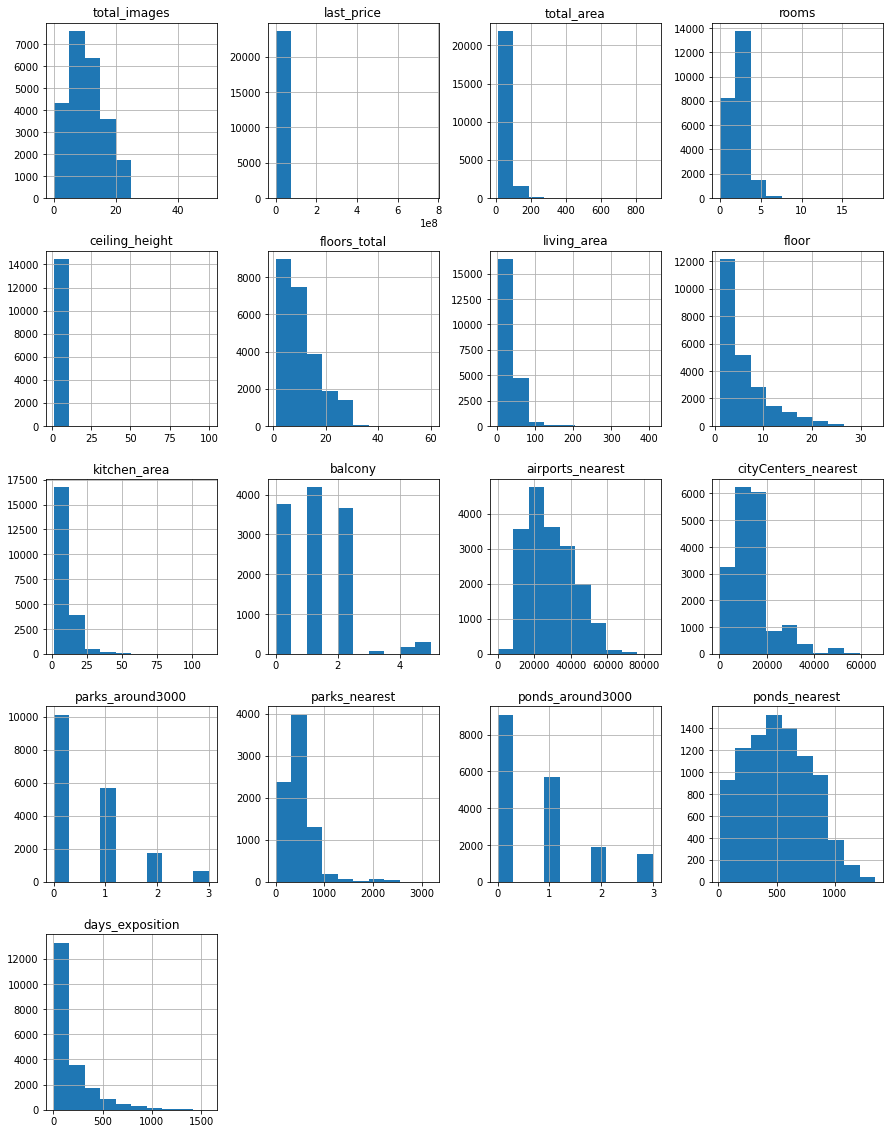

In [4]:
df.hist(figsize=(15, 20))

In [5]:
df.duplicated().sum()

0

По предварительной оценке данный можно сказать, что явные дубликаты отсутствуют, но в некоторых столбцах есть пропущенные данные, а так же не везде корректный тип данных. В гистрограммах также встречаются некоторые аномалии. 

### Выполните предобработку данных

Начнем с очевидных ошибок в названиях столбцов. cityCenters_nearest не соответствует правилам стиля, исправим это:

In [6]:
df.rename(columns = {'cityCenters_nearest':'city_centers_nearest'}, inplace = True )

Сразу изменим тип данных в тех столбцах, где это нужно и возможно без дополнительной предобработки:

In [7]:
df['last_price'].astype('int')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


Колонка last_price содержит целые числа, следовательно меняем тип данных на int. Колонка first_day_exposition содержит данные о дате и времени, следовательно меняем тип данных на datetime. 

Заменим значения NaN в столбце ceiling_height на медианное значение высоты потолков:

In [8]:
df['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

В столбце высоты потолков встречаются нереалистично большие значения. Скорее всего, при заполнении данных произошла ошибка и некоторые значения оказались на порядок больше, чем должны быть. Исправим это, поделив все значения, превышающие 20 на 10:

In [9]:
df.loc[df['ceiling_height'] >= 20.0, 'ceiling_height'] = df['ceiling_height']/10
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

Заменим пропуски в столбце floors_total на медианное значение количества этажей:

In [10]:
df['floors_total'] = df['floors_total'].fillna(df['floors_total'].median())

Пропуски в living_area пока оставим без изменений, т.к. данный параметр может оказаться важным в ценообразовании. Лучше позднее более подробно изучить влияние данного столбца на рыночную стоимость недвижимости.

Проверим среднее число аппартаментов:

In [11]:
df['is_apartment'].mean()

0.018018018018018018

Поскольку процент аппартаментов составляет меньше 2%, можно заменить пустые значения на False:

In [12]:
df['is_apartment'] = df['is_apartment'].fillna(False)

    Заменим пропуски в kitchen_area и living_area:

In [13]:
median_living_area = df['living_area'].median()
median_total_area = df['total_area'].median()
ratio1 = median_total_area / median_living_area 
df['living_area'] = df['living_area'].fillna(df['total_area'] / ratio1)

In [14]:
median_kitchen_area = df['kitchen_area'].median()
median_total_area = df['total_area'].median()
ratio2 = median_total_area / median_kitchen_area 
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area'] / ratio2)

Аналогичная ситуация с количеством балконов из столбца balcony - пропуски скорее всего означают отсутствие балконов. Аналогичным образом заменяем пропуски на нули:

In [15]:
df['balcony'] = df['balcony'].fillna(0)

Столбец locality_name это названия населенных пунктов. В данном столбце не хватает всего 49 значений (23699-23650). Заменим эти пропуски на "неизвестно":

In [16]:
df['locality_name'] = df['locality_name'].fillna('unknown')

Переведем регистр всех названий в строчные буквы:

In [17]:
df['locality_name'] = df['locality_name'].str.lower()

Избавимся от явных дубликатов в названиях:

In [18]:
df['locality_name'] = (
    df['locality_name']
    .str.replace('ё','е')
    .replace(['городской поселок ','деревня ', 'коттеджный поселок ', 'поселок ',
             'посёлок городского типа ', 'садоводческое некоммерческое товарищество ', 'садовое товарищество ', 'село ', 'городского типа ', 'при железнодорожной станции ', 'станции '], '', regex=True)
)

Пропуски в столбце airport_nearest могут означать, что в данном населенном пункте аэропорта нет. В данном случае пропуски лучше оставить.

Пропуски в столбце city_centers_nearest могут означать, что данная недвижимость находится за пределами города. В данном случае пропуски оставим.

Пропуски в столбце parks_nearest могут означать, что данная недвижимость находится слишком далеко от парков. В данном случае пропуски оставим.

Пропуски в столбце ponds_nearest оставим без изменений.

Пропуски в столбце days_exposition могут означать, что данная недвижимость находится слишком далеко от водоемов. В данном случае пропуски оставим.

Изменим тип данных изменённых столбцов:

In [19]:
df['floors_total'].astype('int')
df['is_apartment'].astype('bool')
df['balcony'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

По итогам предобработки данных были удалены явные и неявные дубликаты, переименован один из столбцов, уменьшено количество пропусков в таблице и изменены типы данных там, где это было необходимо. Так же были обработаны найденные аномалии.

### Добавьте в таблицу новые столбцы

Добавим в таблицу столбец с ценой одного квадратного метра:

In [20]:
df['price_sq_m'] = (df['last_price'] / df['total_area']).round(2)

Добавим столбцы с днем недели, месяцем и годом публикации объявления:

In [21]:
df['day_publication'] = df['first_day_exposition'].dt.weekday
df['month_publication'] = df['first_day_exposition'].dt.month
df['year_publication'] = df['first_day_exposition'].dt.year

Добавим столбец с типом этажа квартиры:

In [22]:
def floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['type_apartment_floor'] = df.apply(floor, axis=1)

Добавим столбец с расстоянием до центра города в км:

In [23]:
df['distance_city_center'] = (df['city_centers_nearest'] / 1000).round(0)


    Посмотрим на дополненный датасет:

In [24]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,day_publication,month_publication,year_publication,type_apartment_floor,distance_city_center
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,False,False,False,25.000,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,False,False,False,11.000,2.0,шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,False,False,False,8.300,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,91.730769,9,False,False,False,27.825,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,False,False,False,41.000,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

**Общая площадь**

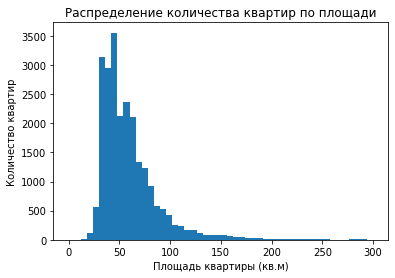

In [25]:
df['total_area'].plot.hist(bins=50, range=(0, 300))
plt.title('Распределение количества квартир по площади')
plt.xlabel('Площадь квартиры (кв.м)')
plt.ylabel('Количество квартир')
plt.show()

Больше всего на продажу выставлено квартир с площадью около 55 кв.м. Далее следуют квартиры с площадью около 30 кв.м и 65 кв.м.

**Жилая площадь**

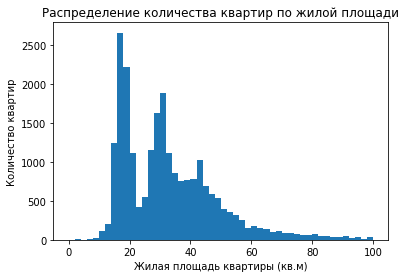

In [26]:
plt.hist(df['living_area'], bins=50, range=(0,100))
plt.title('Распределение количества квартир по жилой площади')
plt.xlabel('Жилая площадь квартиры (кв.м)')
plt.ylabel('Количество квартир')
plt.show()

Больше всего на продажу выставлено квартир с жилой площадью около 18 кв.м. Далее следуют квартиры с жилой площадью около 19 кв.м и 32 кв.м. 

**Площадь кухни**

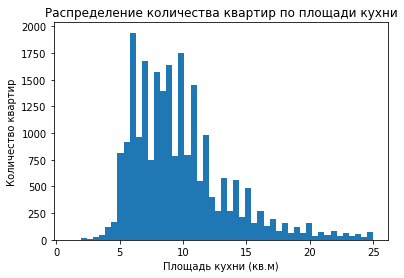

In [27]:
plt.hist(df['kitchen_area'], bins=50, range=(1,25))
plt.title('Распределение количества квартир по площади кухни')
plt.xlabel('Площадь кухни (кв.м)')
plt.ylabel('Количество квартир')
plt.show()

Больше всего на продажу выставлено квартир с площадью кухни около 6 кв.м.  Далее следуют квартиры с площадью кухни 10 кв.м. Квартиры с площадями кухни от 7 до 9 метров также популярны.

**Цена на квартиру**

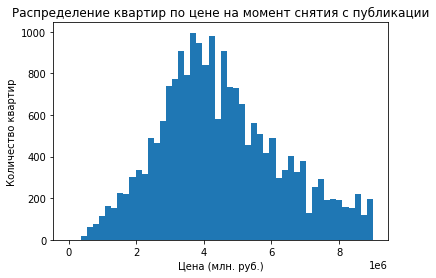

In [28]:
plt.hist(df['last_price'], bins=50, range=(0,9.00000e+06))
plt.title('Распределение квартир по цене на момент снятия с публикации')
plt.xlabel('Цена (млн. руб.)')
plt.ylabel('Количество квартир')
plt.show()

Больше всего объявлений о продаже квартир с ценой около 4 миллионов.

**Количество комнат**

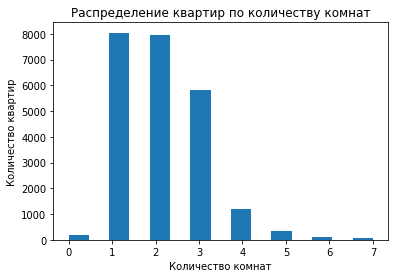

In [29]:
plt.hist(df['rooms'], bins=15, range=(0,7))
plt.title('Распределение квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

Больше всего объявлений о продаже 1-комнатных и 2-комнатных квартир.

**Высота потолков**

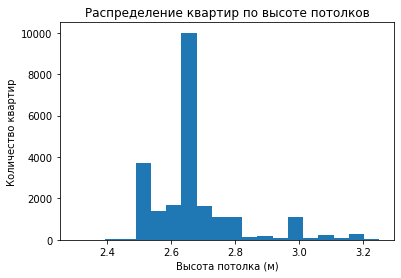

In [30]:
plt.hist(df.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=20, range=(2.3,3.25))
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолка (м)')
plt.ylabel('Количество квартир')
plt.show()

Самая распространенная среди объявлений высота потолка составляет 2.65 метров.


**Тип этажа квартиры**

Поскольку всего три категории нагляднее будет построить pie chart.

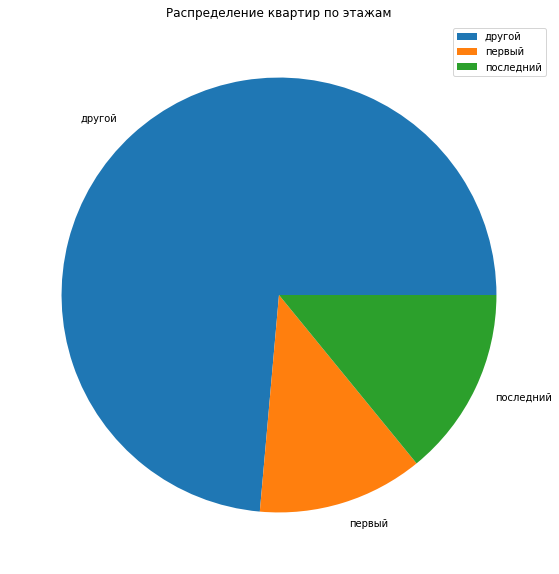

In [31]:
df.pivot_table(index='type_apartment_floor',values='last_price',aggfunc='count').plot.pie(y='last_price', figsize=(15,10), label='', title='Распределение квартир по этажам')
plt.show()

Квартиры на первом и последнем этажах составляют в сумме примерно 25% от общего количества квартир.

**Количество этажей в доме**

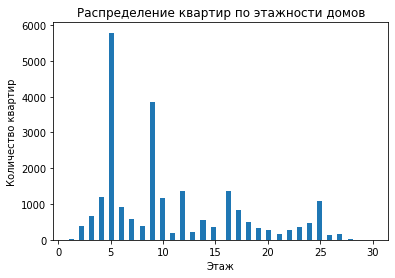

In [32]:
plt.hist(df['floors_total'], bins=60, range=(1,30))
plt.title('Распределение квартир по этажности домов')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
plt.show()

Больше всего пытаются продать квартир в пятиэтажках.

**Расстояние до центра города**

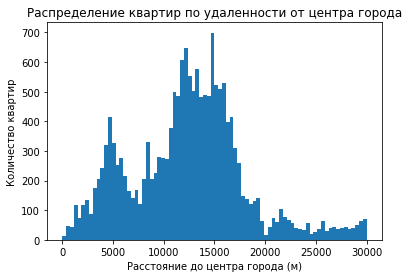

In [33]:
plt.hist(df['city_centers_nearest'], bins=80, range=(0,30000))
plt.title('Распределение квартир по удаленности от центра города')
plt.xlabel('Расстояние до центра города (м)')
plt.ylabel('Количество квартир')
plt.show()

Больше всего предложений о продаже на расстоянии 12-15 километров. Также немало объявлений о продаже квартир в 5 километрах от  центра.


**Расстояние до ближайшего парка**

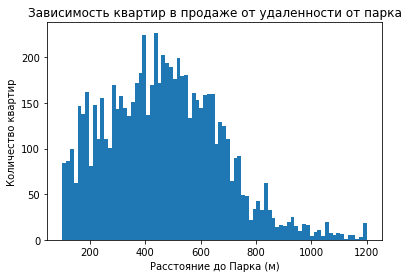

In [34]:
plt.hist(df['parks_nearest'], bins=80, range=(100,1200))
plt.title('Зависимость квартир в продаже от удаленности от парка')
plt.xlabel('Расстояние до Парка (м)')
plt.ylabel('Количество квартир')
plt.show()

Большее число квартир находится от 200 до 650 метров от парков.


Сравним формы изначального и модифицированного датасетов:

In [35]:
shape2 = df.shape 

In [36]:
print('\nOriginal DataFrame Shape :', shape)
print('\nOriginal Number of rows :', shape[0]) 
print('\nOriginal Number of columns :', shape[1])
print('\nNew DataFrame Shape :', shape2)
print('\nNew Number of rows :', shape2[0]) 
print('\nNew Number of columns :', shape2[1])


Original DataFrame Shape : (23699, 22)

Original Number of rows : 23699

Original Number of columns : 22

New DataFrame Shape : (23699, 28)

New Number of rows : 23699

New Number of columns : 28


Число данных в новом датасете позволяет провести дальнейший анализ данных.

# Исследование того, как быстро продавались квартиры

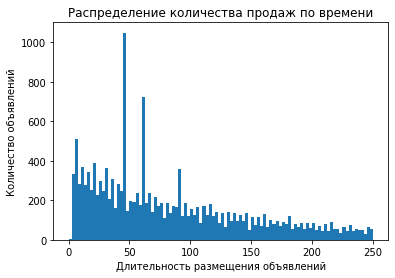

In [37]:
plt.hist(df['days_exposition'], bins=100, range=(0,250))
plt.title('Распределение количества продаж по времени')
plt.xlabel('Длительность размещения объявлений')
plt.ylabel('Количество объявлений')
plt.show()

In [38]:
print(df['days_exposition'].describe())

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


В среднем квартиры продаются за 95 дней (медианное значение). На гистограмме наблюдаются пики снятия предложений на 45 и 60 дни.
Быстрыми можно считать продажи до 45 дней (первый квартиль), чрезвычайно долгими - от 230 дней (четвертый квартиль).

**Факторы, которые больше всего влияют на общую (полную) стоимость объекта.**

Изучим, зависимость цены от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

In [39]:
target_column = 'last_price'
numerical_cols = ['total_area', 'living_area', 'rooms', 
                  'floors_total', 'kitchen_area', 'days_exposition', 'price_sq_m', 
                  'distance_city_center']
filtered_df = df[numerical_cols]
for col in filtered_df:
  
  if col != target_column:
    
    correlation = df[target_column].corr(df[col])
    
    print(f"Корреляция между '{target_column}' и '{col}': {correlation:.2f}")

Корреляция между 'last_price' и 'total_area': 0.65
Корреляция между 'last_price' и 'living_area': 0.59
Корреляция между 'last_price' и 'rooms': 0.36
Корреляция между 'last_price' и 'floors_total': -0.01
Корреляция между 'last_price' и 'kitchen_area': 0.51
Корреляция между 'last_price' и 'days_exposition': 0.08
Корреляция между 'last_price' и 'price_sq_m': 0.74
Корреляция между 'last_price' и 'distance_city_center': -0.21


Показатели корреляции практически не изменились, значит исходные данные имели малое количество выбросов.
корреляция между ценой продажи и общей площадью квартиры - средняя,
корреляция между ценой продажи и жилой площадью квартиры - средняя,
корреляция между ценой за кв.м и ценой продажи квартиры - средняя,
корреляция между ценой продажи квартиры и количеством комнат - слабая.
корреляция между остальными параметрами и ценой продажи квартиры - очень слабая.

Посмотрим на корреляцию между ценой и датой размещения:

In [40]:
target_column = 'last_price'
numerical_cols = ['day_publication', 'month_publication', 'year_publication']
filtered_df = df[numerical_cols]
for col in filtered_df:
  
  if col != target_column:
    
    correlation = df[target_column].corr(df[col])
    
    print(f"Корреляция между '{target_column}' и '{col}': {correlation:.2f}")

Корреляция между 'last_price' и 'day_publication': 0.00
Корреляция между 'last_price' и 'month_publication': 0.00
Корреляция между 'last_price' и 'year_publication': -0.04


Корреляции между ценой и датой размещения не наблюдается.

Построим диграммы рассеяния:

Избавимся от выбросов:

In [41]:
def filter_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    filtered_df = df.loc[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr), :]
    return filtered_df
for col in numerical_cols:
    filtered_df = filter_iqr(df.copy(), col)
    correlation = filtered_df[target_column].corr(filtered_df[col])
    print(f"Корреляция между '{target_column}' и '{col}' : {correlation:.2f}")

Корреляция между 'last_price' и 'day_publication' : 0.00
Корреляция между 'last_price' и 'month_publication' : 0.00
Корреляция между 'last_price' и 'year_publication' : -0.01


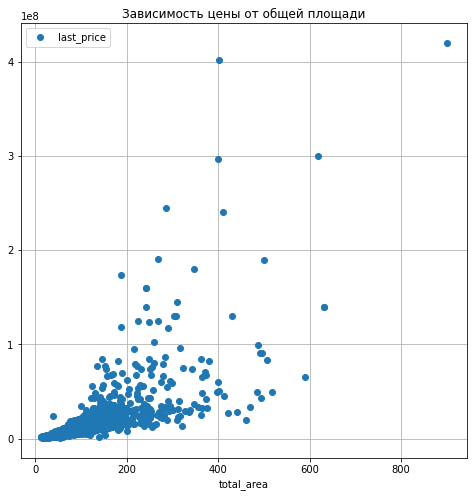

In [42]:
(df.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o', figsize=(8, 8)))
plt.title('Зависимость цены от общей площади')
plt.show()

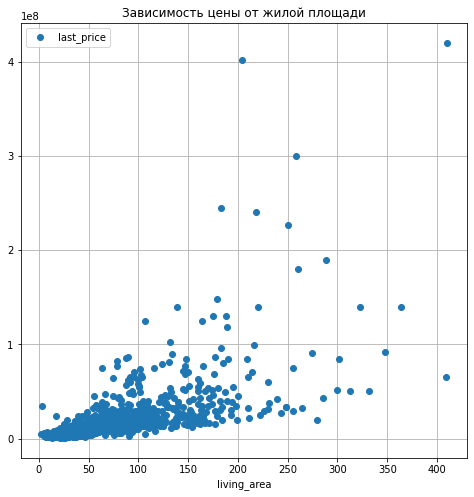

In [43]:
(df.pivot_table(index='living_area', values='last_price').plot(grid=True, style='o', figsize=(8, 8)))
plt.title('Зависимость цены от жилой площади')
plt.show()

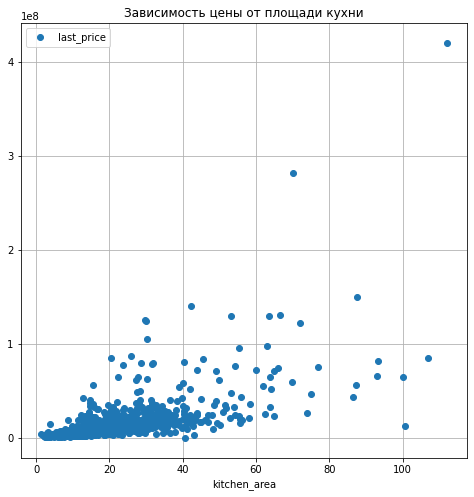

In [44]:
(df.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, style='o', figsize=(8, 8)))
plt.title('Зависимость цены от площади кухни')
plt.show()

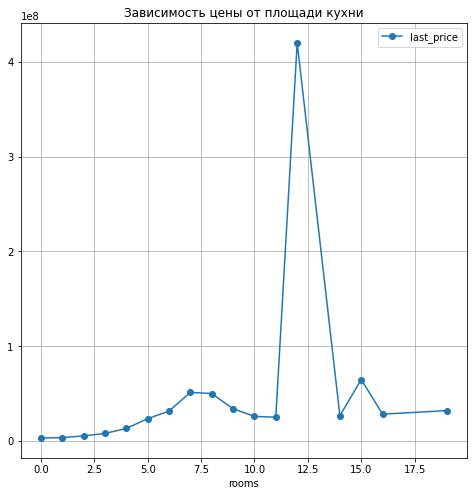

In [45]:
(df.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость цены от площади кухни')
plt.show()

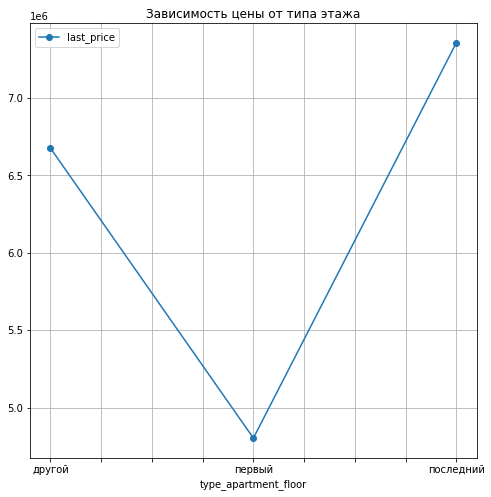

In [46]:
(df.pivot_table(index='type_apartment_floor', values='last_price').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость цены от типа этажа')
plt.show()

Хорошо видно, что цена на квартиры на первом и последнем этажах ниже, чем на других.

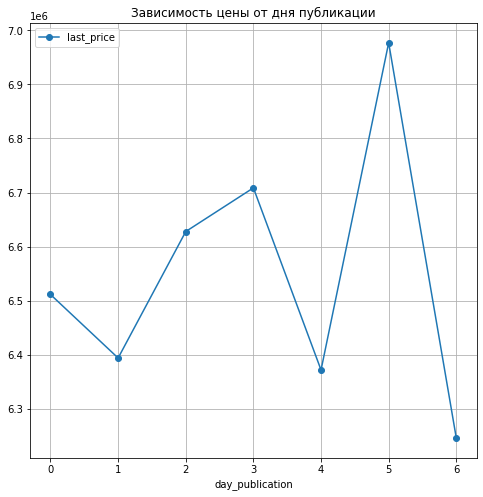

In [47]:
(df.pivot_table(index='day_publication', values='last_price').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость цены от дня публикации')
plt.show()

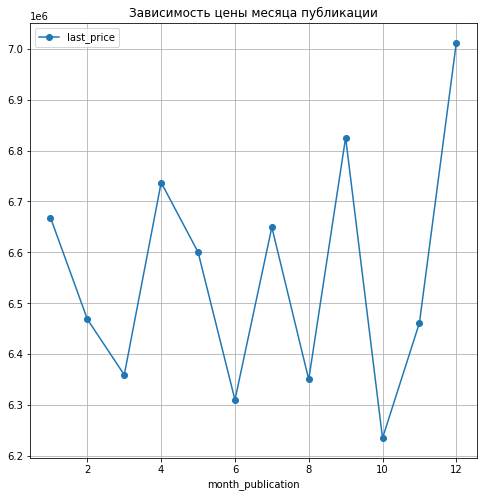

In [48]:
(df.pivot_table(index='month_publication', values='last_price').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость цены месяца публикации')
plt.show()

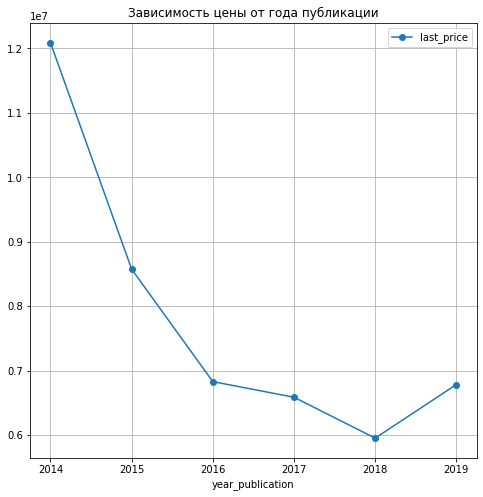

In [49]:
(df.pivot_table(index='year_publication', values='last_price').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость цены от года публикации')
plt.show()

Хорошо видна тенденция изменения цены по годам: с 2014 по 2017 наблюдался резкий спад, а с 2018 к 2019 начался подъем в цене.

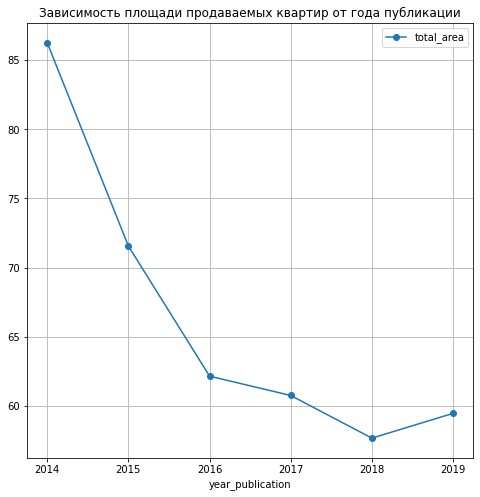

In [50]:
(df.pivot_table(index='year_publication', values='total_area').plot(grid=True, style='o-', figsize=(8, 8)))
plt.title('Зависимость площади продаваемых квартир от года публикации')
plt.show()

Тенденция изменения цены по годам совпадает со снижением площади продаваемых квартир: с 2014 по 2018 площадь продаваемых квартир упала с 87 до 55 кв.м.  



**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений**

In [51]:
price_sqm_locality = df.pivot_table(index='locality_name', values='last_price', aggfunc=['count'])
price_sqm_locality.columns = ['count']
price_sqm_locality = price_sqm_locality.sort_values(by='count', ascending=False).head(10)
price_sqm_locality['price_sq_m'] = df.pivot_table(index='locality_name', values='price_sq_m').round(2)
price_sqm_locality.sort_values(by='price_sq_m', ascending=False)


,count,price_sq_m
locality_name,,
санкт-петербург,15721,114849.01
пушкин,369,103125.82
кудрово,472,95324.93
парголово,327,90175.91
мурино,590,86087.51
шушары,440,78677.36
колпино,338,75424.58
гатчина,307,68746.15
всеволожск,398,68654.47


Дороже всего квадратный метр жилья в Санкт-Петербурге. Наименьшая стоимость метра жилья в Выборге.

Вычислим среднюю стоимость квартир в Санкт-Петербурге в зависимсоти от удаленности от центра города.

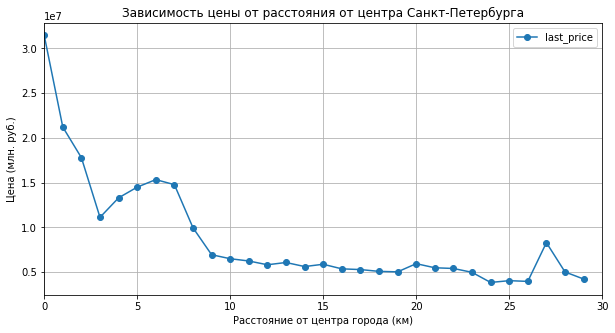

In [52]:
(
    df.query('locality_name == "санкт-петербург"')
    .pivot_table(index='distance_city_center', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,30), figsize=(10, 5))
)
plt.title('Зависимость цены от расстояния от центра Санкт-Петербурга')
plt.xlabel('Расстояние от центра города (км)')
plt.ylabel('Цена (млн. руб.)')
plt.show()

Как видно из графика самые дорогие квартиры - в центре. Стоимость квартир снижается с удалением от центра города. Начиная с удаленности в 10км стоимость практически не меняется. Есть небольшое увеличение в стоимости в 27-28км от города, что может быть связано с элитным жильем на окраине города.

### Напишите общий вывод

Был проведен анализ объявлений о продаже квартир по следующим шагам:
#### Проведен **предварительный анализ данных** 
 - Было выяснено, что в данных для ряда столбцов есть пропущенные значения и неправильный тип данных. Явных дубликатов обнаружено не было. 
#### **Была выполнена предобработка данных**:
 - Столбец cityCenters_nearest был переименован на city_centers_nearest
 - Заполнены явные пропуски в данных.
 - Был изменен тип данных столбцов на корректный.
 - Появление пропусков, скорее всего, связано с человеческим фактором - люди, размещавшие объявление не заполняли все поля.
#### **Добавлены новые столбцы**
 - price_square_meter - цена квадратного метра объекта
 - day_publication - день недели публикации объявления
 - month_publication - месяц публикации объявления
 - year_publication - год публикации объявления
 - type_apartment_floor - тип этажа квартиры
 - distance_city_center - расстояние до центра города в целых километрах
#### **Проведен исследовательский анализ данных**
 - Больше всего на продажу выставлено квартир с площадью около 55 кв.м. Далее следуют квартиры с площадью около 30 кв.м и 65 кв.м.
 - Больше всего на продажу выставлено квартир с жилой площадью около 18 кв.м. Далее следуют квартиры с жилой площадью около 19 кв.м и 32 кв.м.
 - Больше всего на продажу выставлено квартир с площадью кухни около 6 кв.м. Далее следуют квартиры с площадью кухни 10 кв.м. Квартиры с площадями кухни от 7 до 9 метров также популярны.
 - Больше всего объявлений о продаже квартир с ценой около 4 миллионов.
 - Больше всего объявлений о продаже 1-комнатных и 2-комнатных квартир.
 - Самая распространенная среди объявлений высота потолка составляет 2.6 метров.
 - Квартиры на первом и последнем этажах составляют в сумме примерно 25% от общего количества квартир. Цена на квартиры на первом и последнем этажах ниже, чем на других.
 - Больше всего пытаются продать квартир в пятиэтажках.
 - Больше всего предложений о продаже на расстоянии 12-15 километров. Также немало объявлений о продаже квартир в 5 километрах от центра.
 - Большее число квартир находится от 200 до 650 метров от парков.
 - В среднем квартиры продаются за 95 дней (медианное значение). На гистограмме наблюдаются пики снятия предложений на 45 и 60 дни. Быстрыми можно считать продажи до 45 дней (первый квартиль), чрезвычайно долгими - от 230 дней (четвертый квартиль).
 - Корреляция между ценой продажи и общей площадью квартиры - средняя, корреляция между ценой продажи и жилой площадью квартиры - средняя, корреляция между ценой за кв.м и ценой продажи квартиры - средняя, корреляция между ценой продажи квартиры и количеством комнат - слабая. корреляция между остальными параметрами и ценой продажи квартиры - очень слабая.
 - Была показана тенденция изменения цены по годам: с 2014 по 2017 наблюдался резкий спад, а с 2017 к 2019 начался подъем в цене.
 - Была посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений:
     - Дороже всего квадратный метр жилья в Санкт-Петербурге. Наименьшая стоимость метра жилья в Выборге.
     - Было показано, что самые дорогие квартиры - в центре. Стоимость квартир снижается с удалением от центра города. Начиная с удаленности в 10км стоимость практически не меняется. Есть небольшое увеличение в стоимости в 27-28км от города, что может быть связано с элитным жильем на окраине города.